In [3]:
import pickle
import os
import pandas as pd
from prody import writePDB, AtomGroup
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", None)

In [2]:
path_to_database = '/mnt/e/DesignData/vdM_database_20210617/'  # Your path will be different.

In [3]:
path_to_sample_list = [path_to_database, 'sampling/', 'conh2/', 'all_contacts/', 'A/', 'all/', 'LYS.pkl']
path_to_sample = ''.join(path_to_sample_list)

vdm_db = pd.read_pickle(path_to_sample)   # load database

In [4]:
vdm_db.head(7)

,chain,resname,name,c_x,c_y,c_z,c_D_x,c_D_y,c_D_z,c_H1_x,c_H1_y,c_H1_z,c_H2_x,c_H2_y,c_H2_z,c_H3_x,c_H3_y,c_H3_z,c_H4_x,c_H4_y,c_H4_z,c_A1_x,c_A1_y,c_A1_z,c_A2_x,c_A2_y,c_A2_z,atom_type_label,chi1,chi2,chi3,chi4,rotamer,phi,psi,dssp,dssp_acc,rota,CG,probe_name
0,Y,ASN,CB,-1.420542,9.701407,-2.358657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
1,Y,ASN,CG,-0.164165,9.186457,-3.031453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,co,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
2,Y,ASN,OD1,0.299358,8.087146,-2.718096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.554,7.126,40.898998,10.976,7.976,41.687,o,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
3,Y,ASN,ND2,0.414054,10.005791,-3.892476,11.782,8.963,41.335999,12.040,9.038,40.519001,12.048,9.531,41.924999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
4,Y,ASN,HD21,1.154619,9.782300,-4.268361,11.782,8.963,41.335999,12.040,9.038,40.519001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h_pol,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
5,Y,ASN,HD22,0.048982,10.762636,-4.077437,11.782,8.963,41.335999,12.048,9.531,41.924999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h_pol,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
6,X,LYS,CB,-0.526650,0.836092,-1.169956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,293.3,167.5,184.7,165.0,mttt,-63.1,-27.3,H,0.0,1,1,1M40_biomol_1_A_A


In brief, the files in the "sampling" folder contain the coordinates (c_x, c_y, c_z) of sidechains (chain X) and the chemical group of interest (chain Y).  Individual instances of vdMs have unique identifiers made from three columns in the DataFrame: 'rota', 'CG', and 'probe_name'.  If you group a DataFrame by these columns (using the groupby method in Pandas), you can iterate through each vdM instance.  A vdM is defined by the column "cluster_number".  The chemical groups in the library are built from parts of amino acids in the PDB.  The labels of the folders describe the atoms in the chemical group (ccn = CD-CE-NZ of lysine, coo = carboxylate of asp/glu, etc).

Files in the "scoring" folder contain cluster scores, and files in the "info" folder contain information about the vdM instances (e.g. what PDB they came from, etc.)

The folders are organized by ABPLE assingment, which is a partitioning of the ramachandran map of each residue type (A = alpha helical region, B = beta sheet, P = poly proline, L = left-handed helix, E = extended, see Sali and Blundell, J. Mol. Biol. 1993, 234, 779-815, specifically figure 3.) Phi/psi values can be easily mapped to ABPLE assignments and COMBS uses these assignments to account for backbone-dependence of the interactions.  Alternatively, DSSP assignments can be used (and found in the info database) or more fine-grained phi/psi binning.  We chose ABPLE assignments because it maximizes the number of counts in each category (There are only 5 categories instead of e.g. 36 x 36 = 1296 bins of phi/psi space in 10 deg increments.) and seems to capture the essential features of the backbone dependence.  Here is how the ABPLE mapping is calculated:

In [5]:
def get_ABPLE(resn, phi, psi):
    try:
        psi = int(np.ceil(psi / 10.0)) * 10
        phi = int(np.ceil(phi / 10.0)) * 10
        if psi == -180:
            psi = -170
        if phi == -180:
            phi = -170
        return abple_dict[resn][psi][phi]
    except ValueError:
        return 'n'

with open(path_to_database + 'abple_dict.pkl', 'rb') as infile:
    abple_dict = pickle.load(infile)

get_ABPLE('LYS', -60, -40)  # Lysine in the alpha helical region (A).

'A'

vdMs are defined by their cluster numbers, and vdM instances by 3 tags: rota, CG, and probe_name. For example,

In [6]:
grouped_vdm_db = vdm_db.groupby(['rota', 'CG', 'probe_name'])
vdm_instance = grouped_vdm_db.get_group((1, 1, '1M40_biomol_1_A_A'))
vdm_instance

,chain,resname,name,c_x,c_y,c_z,c_D_x,c_D_y,c_D_z,c_H1_x,c_H1_y,c_H1_z,c_H2_x,c_H2_y,c_H2_z,c_H3_x,c_H3_y,c_H3_z,c_H4_x,c_H4_y,c_H4_z,c_A1_x,c_A1_y,c_A1_z,c_A2_x,c_A2_y,c_A2_z,atom_type_label,chi1,chi2,chi3,chi4,rotamer,phi,psi,dssp,dssp_acc,rota,CG,probe_name
0,Y,ASN,CB,-1.420542,9.701407,-2.358657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
1,Y,ASN,CG,-0.164165,9.186457,-3.031453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,co,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
2,Y,ASN,OD1,0.299358,8.087146,-2.718096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.554,7.126,40.898998,10.976,7.976,41.687,o,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
3,Y,ASN,ND2,0.414054,10.005791,-3.892476,11.782,8.963,41.335999,12.040,9.038,40.519001,12.048,9.531,41.924999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
4,Y,ASN,HD21,1.154619,9.782300,-4.268361,11.782,8.963,41.335999,12.040,9.038,40.519001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h_pol,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
5,Y,ASN,HD22,0.048982,10.762636,-4.077437,11.782,8.963,41.335999,12.048,9.531,41.924999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h_pol,283.3,321.5,NaN,NaN,m-40,-79.0,-38.7,H,19.0,1,1,1M40_biomol_1_A_A
6,X,LYS,CB,-0.526650,0.836092,-1.169956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,293.3,167.5,184.7,165.0,mttt,-63.1,-27.3,H,0.0,1,1,1M40_biomol_1_A_A
7,X,LYS,CG,-0.202296,2.321340,-0.984692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,293.3,167.5,184.7,165.0,mttt,-63.1,-27.3,H,0.0,1,1,1M40_biomol_1_A_A
8,X,LYS,CD,-0.428425,3.165664,-2.222188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,293.3,167.5,184.7,165.0,mttt,-63.1,-27.3,H,0.0,1,1,1M40_biomol_1_A_A
9,X,LYS,CE,0.026244,4.597346,-1.986543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,293.3,167.5,184.7,165.0,mttt,-63.1,-27.3,H,0.0,1,1,1M40_biomol_1_A_A


In [7]:
for group_name, vdm_instance in grouped_vdm_db:
    break # perform some operation

The following function prints a dataframe (or part of a dataframe) to a PDB.

In [8]:
def print_dataframe_to_PDB(df, outpath='./', filename='', tag='', prefix='',
                    resnum=10, ideal_ala_bb=None):
    """

    Parameters
    ----------
    df : :class:`pandas.DataFrame`
        DataFrame to be printed as a PDB file
    outpath: str
        Path to output directory
    filename: str
        Filename
    tag: str
        Tag appended to the filename
    prefix : str
        Tag prepended to the filename
    resnum: int, default=10
        Residue number for the dataframe to be printed
    ideal_ala_bb: :class:`pandas.DataFrame`, default=None
        DataFrame to be appended to *df*, such as the
        backbone atoms of the "ideal alanine" to which vdMs
        were superposed.

    Returns
    -------

    """
    df = df.copy()
    try:
        os.makedirs(outpath)
    except:
        pass
    if filename == '':
        cg = df.CG.iat[0]
        rota = df.rota.iat[0]
        probe_name = df.probe_name.iat[0]
        filename = 'CG_'+ str(cg) + '_rota_' + str(rota) + '_' + probe_name
    if 'resnum' not in df.columns:
        df['resnum'] = resnum
    if ideal_ala_bb is not None:
        df = pd.concat((df, ideal_ala_bb))
    ag = AtomGroup()
    ag.setCoords(df[['c_x','c_y','c_z']].values)
    ag.setResnums(df['resnum'].values)
    ag.setResnames(df['resname'].values)
    ag.setNames(df['name'].values)
    ag.setChids(df['chain'].values)
    ag.setSegnames(df['chain'].values)
    if 'beta' in df.columns:
        ag.setBetas(df['beta'].values)
    if 'occ' not in df.columns:
        df['occ'] = 1
    writePDB(outpath + prefix + filename + tag + '.pdb.gz', ag, occupancy=df['occ'].values)



All of the vdM coordinates in the sampling folder have been superimposed by the backbone N, Ca, C atoms onto the corresponding atoms of an "ideal alanine" residue. This puts all the vdM instances in the same reference frame and allows us to drop the backbone coordinates to reduce the filesize of the databases.  Note that the exact backbone coordinates can be found either in the original pdb files or in the "parent" dataframes.  The parent dataframes are conglomerates of the sampling, scoring, and info dataframes, and contain all the backbone atoms, as well as a few backbone atoms of the residue before and after (chain X, resnum 9 and 11, respectively, in the parent dataframe).

In [9]:
path_to_ideal_ala_bb = path_to_database + 'ideal_alanine/'
ideal_ala_bb = pd.read_pickle(path_to_ideal_ala_bb + 'ideal_alanine_bb_only.pkl')
print_dataframe_to_PDB(vdm_instance, outpath = path_to_database + 'tutorial/tutorial_output/',
                filename='vdm_instance_1_1_1M40_biomol_1_A_A', ideal_ala_bb=ideal_ala_bb)


Filter vdMs by rotamer.

In [10]:
vdm_db_x = vdm_db[vdm_db.chain == 'X'] # exclude the CG (chain Y) from analysis
vdm_db_x_unique = vdm_db_x[['rota', 'CG', 'probe_name', 'rotamer']].drop_duplicates() # drop duplicates due to multiple atoms within a vdM instance.
vdm_db_x_unique.rotamer.value_counts() # count number of each type of rotamer label

mttt       1264
tttt        618
mmtt        486
mttm        317
mttp        282
mtpt        239
mtmt        237
pttt        194
tptt        171
tttp        168
tttm        163
ttpt        134
mmtm        104
mmmt        101
ttmt         93
mtpp         83
mmtp         74
tptm         66
OUTLIER      64
mtmm         53
tppt         51
pttm         49
pttp         46
tmtt         43
ttmm         42
tptp         34
ttpp         32
ptpt         31
ptmt         26
mptt         22
ptpp         18
tppp         12
mmmm         10
mmpt         10
tmmt          9
mtmp          6
mtpm          4
pptt          4
mptp          3
tmmm          3
tmtp          3
pmtt          2
ptmm          2
mptm          1
ttmp          1
mppt          1
ttpm          1
tmtm          1
Name: rotamer, dtype: int64

In [11]:
vdm_db_x_unique_mttt = vdm_db_x_unique[vdm_db_x_unique.rotamer == 'mttt']
vdm_db_mttt = pd.merge(vdm_db, vdm_db_x_unique_mttt[['rota', 'CG', 'probe_name']],
                       on=['rota', 'CG', 'probe_name'])
vdm_db_mttt[['chain', 'name', 'rotamer', 'rota', 'CG', 'probe_name']].head(50)

,chain,name,rotamer,rota,CG,probe_name
0,Y,CB,m-40,1,1,1M40_biomol_1_A_A
1,Y,CG,m-40,1,1,1M40_biomol_1_A_A
2,Y,OD1,m-40,1,1,1M40_biomol_1_A_A
3,Y,ND2,m-40,1,1,1M40_biomol_1_A_A
4,Y,HD21,m-40,1,1,1M40_biomol_1_A_A
5,Y,HD22,m-40,1,1,1M40_biomol_1_A_A
6,X,CB,mttt,1,1,1M40_biomol_1_A_A
7,X,CG,mttt,1,1,1M40_biomol_1_A_A
8,X,CD,mttt,1,1,1M40_biomol_1_A_A
9,X,CE,mttt,1,1,1M40_biomol_1_A_A


More information about the vdMs can be found in the info folder, such as the pdb resnum and chain ID.

In [12]:
path_to_info_list = [path_to_database, 'info/', 'conh2/', 'all_contacts/', 'dataframes/', 'LYS.pkl']
path_to_info = ''.join(path_to_info_list)

info_db = pd.read_pickle(path_to_info)


In [13]:
info_db.head(20)

,index,name,chain,resnum,resname,beta,occ,rscc,rsr,rsrz,pdb_chain,pdb_segment,pdb_resnum,dssp_seq,contact_hb,contact_wh,contact_cc,contact_so,partners_hb,partners_wh,partners_cc,partners_so,rota,CG,seq,pdb_name,probe_name,centroid,cluster_number,cluster_size,cluster_atom,cluster_order,ABPLE,rep_centroid,rep_cluster_number,rep_cluster_size,rep_cluster_score,sub_rep_centroid,sub_rep_cluster_number,sub_rep_cluster_size,sub_rep_cluster_score
0,0,CB,Y,10,ASN,6.89,1.0,0.998,0.038,-0.851,A,A,132,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,True,4.0,A,False,1,78,2.738887,True,1,1,0.0
1,1,CG,Y,10,ASN,6.98,1.0,0.998,0.038,-0.851,A,A,132,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,True,5.0,A,False,1,78,2.738887,True,1,1,0.0
2,2,OD1,Y,10,ASN,7.46,1.0,0.998,0.038,-0.851,A,A,132,HHHSCCHHHHHHH,True,NaN,NaN,NaN,HZ1,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,True,6.0,A,False,1,78,2.738887,True,1,1,0.0
3,3,ND2,Y,10,ASN,8.71,1.0,0.998,0.038,-0.851,A,A,132,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,True,7.0,A,False,1,78,2.738887,True,1,1,0.0
4,4,HD21,Y,10,ASN,8.71,1.0,0.998,0.038,-0.851,A,A,132,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,False,NaN,A,False,1,78,2.738887,True,1,1,0.0
5,5,HD22,Y,10,ASN,8.71,1.0,0.998,0.038,-0.851,A,A,132,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,False,NaN,A,False,1,78,2.738887,True,1,1,0.0
6,10,CB,X,10,LYS,6.51,1.0,0.997,0.034,-1.236,A,A,73,ECGGGHHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,True,3.0,A,False,1,78,2.738887,True,1,1,0.0
7,11,CG,X,10,LYS,6.71,1.0,0.997,0.034,-1.236,A,A,73,ECGGGHHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,False,NaN,A,False,1,78,2.738887,True,1,1,0.0
8,12,CD,X,10,LYS,6.69,1.0,0.997,0.034,-1.236,A,A,73,ECGGGHHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,False,NaN,A,False,1,78,2.738887,True,1,1,0.0
9,13,CE,X,10,LYS,7.31,1.0,0.997,0.034,-1.236,A,A,73,ECGGGHHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,1M40_biomol_1_A_A,False,7,76,False,NaN,A,False,1,78,2.738887,True,1,1,0.0


The nature of the interaction as well as the interaction partner atom(s) can be found in the "contact_" and "partners_" columns. Terms are defined as in the Probe program (Richardson lab, Duke): hb = hydrogen bond, wh = weak hydrogen bond, cc = close contact, so = strong overlap.  Above, you can see this is a sidechain hb interaction between a lysine residue and a CONH2 chemical group, because the contact_hb column contains a "True" and the partners_hb column contains an HZ1 (for row with name = OD1 and chain = Y) and an OD1 (for row with name = HZ1 and chain = X).  Interactions can thus be filtered by type and contacting atoms (e.g., backbone vs sidechain contacts).

Backbone-dependent and independent cluster scores of the vdMs can be found in the scoring folder.

In [14]:
path_to_scoring_list = [path_to_database, 'scoring/', 'conh2/', 'all_contacts/', 'dataframes/', 'LYS.pkl']
path_to_scoring = ''.join(path_to_scoring_list)

scoring_db = pd.read_pickle(path_to_scoring)
scoring_db.head(5)

,index,C_score_hb_dssp_H,C_score_dssp_C,C_score_dssp_E,C_score_hb_abple_E,C_score_abple_A,C_score_bb_ind,C_score_hb_dssp_I,rota,C_score_abple_L,C_score_dssp_H,C_score_dssp_I,probe_name,C_score_dssp_S,C_score_hb_dssp_S,C_score_hb_abple_L,C_score_hb_dssp_E,C_score_hb_dssp_C,C_score_hb_abple_P,C_score_dssp_T,C_score_hb_abple_A,C_score_hb_abple_B,C_score_hb_dssp_T,C_score_dssp_B,C_score_abple_E,C_score_hb_dssp_G,C_score_abple_P,C_score_dssp_G,CG,C_score_abple_B,C_score_hb_dssp_B
0,0,3.103717,0.939685,-0.868632,NaN,3.121727,2.920397,NaN,1,0.826315,3.243580,NaN,1M40_biomol_1_A_A,0.85027,0.689381,0.650914,NaN,0.632928,-0.181538,-0.525618,2.958382,-0.359691,-0.626233,NaN,NaN,-0.583948,0.351812,0.267681,1,0.060521,NaN
1,33,1.615640,0.757363,0.229980,NaN,1.750248,1.847760,NaN,1,NaN,1.889034,NaN,3U5V_biomol_1_A_A,NaN,NaN,NaN,-0.083788,0.409785,-0.181538,0.167530,1.407784,0.556600,-0.626233,NaN,NaN,NaN,-0.053653,NaN,1,0.907818,NaN
2,66,3.103717,0.939685,-0.868632,NaN,3.121727,2.920397,NaN,1,0.826315,3.243580,NaN,5E43_biomol_1_A_A,0.85027,0.689381,0.650914,NaN,0.632928,-0.181538,-0.525618,2.958382,-0.359691,-0.626233,NaN,NaN,-0.583948,0.351812,0.267681,1,0.060521,NaN
3,99,NaN,NaN,NaN,NaN,-1.082965,-1.410336,NaN,1,NaN,-0.883555,NaN,6TZK_biomol_1_A_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4,132,3.103717,0.939685,-0.868632,NaN,3.121727,2.920397,NaN,1,0.826315,3.243580,NaN,1E25_biomol_1_A_A,0.85027,0.689381,0.650914,NaN,0.632928,-0.181538,-0.525618,2.958382,-0.359691,-0.626233,NaN,NaN,-0.583948,0.351812,0.267681,2,0.060521,NaN


Below are a few functions for superimposing and printing clusters from dataframes.  The distance metric is no longer RMSD but is the maximum distance between any two corresponding atoms.  This makes the metric independent of the number of atoms (RMSD is weighted by the number of atoms, such that a good fit in one region could off-set a poor fit in another region), and thus more stringent.  For the vdM databases, to define clusters we used a maximum distance criterion of 0.65 angstroms (which qualitatively corresponds to a RMSD of 0.4 angstroms for CONH2 CGs).

In [15]:
def get_rot_trans(mob_coords, targ_coords):
    """

    Parameters
    ----------
    mob_coords
    targ_coords

    Returns
    -------

    """
    mob_coords_com = mob_coords.mean(0)
    targ_coords_com = targ_coords.mean(0)
    mob_coords_cen = mob_coords - mob_coords_com
    targ_coords_cen = targ_coords - targ_coords_com
    cov_matrix = np.dot(mob_coords_cen.T, targ_coords_cen)
    U, S, Wt = np.linalg.svd(cov_matrix)
    R = np.dot(U, Wt)
    if np.linalg.det(R) < 0.:
        Wt[-1] *= -1
        R = np.dot(U, Wt)
    return R, mob_coords_com, targ_coords_com


# @jit("f4[:,:](f4[:,:,:])", nopython=True, cache=True)
def make_pairwise_maxdist_mat(X):
    """

    Parameters
    ----------
    X

    Returns
    -------

    """
    M = X.shape[0]
    N = X.shape[1]
    O = X.shape[2]
    D = np.zeros((M, M), dtype=np.float32)
    m_com = np.zeros(O, dtype=np.float32)
    t_com = np.zeros(O, dtype=np.float32)
    mtrans = np.zeros((O, N), dtype=np.float32)
    mtr_re = np.zeros(N * O, dtype=np.float32)
    t_re = np.zeros(N * O, dtype=np.float32)
    dists = np.zeros(N, dtype=np.float32)
    for i in range(M):
        for j in range(i + 1, M):
            for k in range(O):
                m_com[k] = np.mean(X[i, :, k])
                t_com[k] = np.mean(X[j, :, k])
            m = np.subtract(X[i, :, :], m_com)
            for a in range(N):
                for b in range(O):
                    mtrans[b, a] = m[a, b]
            t = np.subtract(X[j, :, :], t_com)
            c = np.dot(mtrans, t)
            U, S, Wt = np.linalg.svd(c)
            R = np.dot(U, Wt)
            if np.linalg.det(R) < 0.0:
                Wt[-1, :] *= -1.0
                R = np.dot(U, Wt)
            mtr = np.add(np.dot(m, R), t_com)
            pp = 0
            for a in range(N):
                q = 0
                for b in range(O):
                    mtr_re[q] = mtr[a, b]
                    t_re[q] = X[j, :, :][a, b]
                    q += 1
                sub = np.subtract(mtr_re, t_re)
                dists[pp] = np.sqrt(np.dot(sub, sub))
                pp += 1
            D[i, j] = np.max(dists)
    return D


def print_cluster(df, cluster_num, max_members=0, outpath='./', tag='',
                  coords_exchange_indices_input=None,
                  coords_exchange_indices_output=None):
    """
    Prints members of a cluster to PDB files.

    Parameters
    ----------
    df : :class:`pandas.DataFrame`
        Needs *cluster_number* as a column
    cluster_num : int
        Cluster number to be printed
    max_members : int
        Maximum number of members to be printed for each cluster.
        The cluster centroid is always included in the subgroup.
    outpath : str
        Path to folder for output.  Created if it doesn't exist.
    tag : str
        File tag appended to file name.
    coords_exchange_indices_input : list, tuple
        For symmetric CGs such as carboxylate, flip the CG atoms at these indices.
        See *cluster_order* column for cluster indices.  This is the input order.
    coords_exchange_indices_output : list, tuple
        For symmetric CGs such as carboxylate, flip the CG atoms at these indices.
        See *cluster_order* column for cluster indices. This is the output order.

    Returns
    -------

    """
    df_c0 = df[(df.cluster_number == 1) & df.centroid]
    df_c0_bb10 = df_c0[(df_c0.chain == 'X') & (df_c0.resnum == 10) & (df_c0.name.isin({'CA', 'N', 'C', 'CB'}))]
    df_c0_bb10_coords = df_c0_bb10[['c_x', 'c_y', 'c_z']].values
    df_c = df[(df.cluster_number == cluster_num) & df.centroid]
    df_c_bb10 = pd.merge(df_c0_bb10[['chain', 'resnum', 'name']], df_c, on=['chain', 'resnum', 'name'])
    df_c_bb10_coords = df_c_bb10[['c_x', 'c_y', 'c_z']].values
    # Align backbone of cluster centroid to backbone of centroid of largest cluster.
    R, m_com, t_com = get_rot_trans(df_c_bb10_coords, df_c0_bb10_coords)
    cent_coords = np.dot((df_c[['c_x', 'c_y', 'c_z']].values - m_com), R) + t_com
    df_c = df_c.copy()
    df_c[['c_x', 'c_y', 'c_z']] = cent_coords
    print_dataframe_to_PDB(df_c, outpath, tag='_centroid_1' + tag, prefix='cluster_' + str(cluster_num) + '_')
    max_members -= 1
    if max_members == 0:
        return
    df_nc = df[(df.cluster_number == cluster_num) & ~df.centroid]
    grs = df_nc.groupby(['CG', 'rota', 'probe_name'])
    num_grs = len(grs)
    if max_members < 0 or max_members > num_grs:
        max_members = num_grs
    df_c_cluster_atoms = df_c[df_c.cluster_atom].sort_values('cluster_order')
    for i, (n, gr) in enumerate(grs):
        df_m_cluster_atoms = gr[gr.cluster_atom].sort_values('cluster_order')[['c_x','c_y','c_z']].values
        all_df_m_cluster_atoms = [df_m_cluster_atoms]
        if coords_exchange_indices_input is not None and coords_exchange_indices_output is not None:
            df_m_cluster_atoms_ = df_m_cluster_atoms.copy()
            df_m_cluster_atoms_[coords_exchange_indices_input] = df_m_cluster_atoms_[coords_exchange_indices_output]
            all_df_m_cluster_atoms.append(df_m_cluster_atoms_)
        dfc_coords = df_c_cluster_atoms[['c_x','c_y','c_z']].values
        max_dists = []
        transforms = []
        for coords_ in all_df_m_cluster_atoms:
            R, m_com, t_com = get_rot_trans(coords_, dfc_coords)
            super_coords = np.dot((coords_ - m_com), R) + t_com
            arr = np.array([super_coords, dfc_coords], dtype=np.float32)
            max_dist_mat = make_pairwise_maxdist_mat(arr)
            max_dist_mat = max_dist_mat + max_dist_mat.T
            max_dist = max_dist_mat[0,1]
            max_dists.append(max_dist)
            transforms.append((R, m_com, t_com))

        min_ind = np.argmin(max_dists)
        R, m_com, t_com = transforms[min_ind]
        coords_transformed = np.dot((gr[['c_x','c_y','c_z']].values - m_com), R) + t_com
        df_m = gr.copy()
        df_m[['c_x','c_y','c_z']] = coords_transformed
        print_dataframe_to_PDB(df_m, outpath, tag='_' + str(i + 2) + tag, prefix='cluster_' + str(cluster_num) + '_')
        if i + 2 > max_members:
            return

The exact backbone coordinates of each vdM instance are stored in "parent dataframes".  Some backbone atoms at i+-1 of the contacting residue are also stored, and these are labelled chain X and resnum 9 and 11.  The parent dataframes are conglomerate dataframes that contain all the information found in the sampling, scoring, and info databases.  Below, we use the parent dataframe of LYS residues contacting CONH2 groups to print the top clusters and observed the phi/psi dependence of the interactions.

In [16]:
path_to_parent_database = '/Volumes/disk1/vdM_parent_database/'  # Your path will be different
path_to_parent_df_list = [path_to_parent_database, 'conh2_parent_dataframes/', 'LYS.pkl']
path_to_parent_df = ''.join(path_to_parent_df_list)
df_parent = pd.read_pickle(path_to_parent_df)
df_parent.head(5)

,index,resnum,chain,resname,name,beta,occ,c_x,c_y,c_z,c_D_x,c_D_y,c_D_z,c_H1_x,c_H1_y,c_H1_z,c_H2_x,c_H2_y,c_H2_z,c_H3_x,c_H3_y,c_H3_z,c_H4_x,c_H4_y,c_H4_z,c_A1_x,c_A1_y,c_A1_z,c_A2_x,c_A2_y,c_A2_z,atom_type_label,chi1,chi2,chi3,chi4,evaluation,rotamer,rscc,rsr,rsrz,phi,psi,rama,pdb_chain,pdb_segment,pdb_resnum,dssp,dssp_acc,dssp_seq,contact_hb,contact_wh,contact_cc,contact_so,partners_hb,partners_wh,partners_cc,partners_so,rota,CG,seq,pdb_name,score_index,probe_name,centroid,cluster_number,cluster_size,C_score_bb_ind,cluster_atom,cluster_order,ABPLE,C_score_abple_A,C_score_abple_B,C_score_abple_E,C_score_abple_L,C_score_abple_P,C_score_dssp_B,C_score_dssp_C,C_score_dssp_E,C_score_dssp_G,C_score_dssp_H,C_score_dssp_I,C_score_dssp_S,C_score_dssp_T,C_score_hb_abple_A,C_score_hb_abple_B,C_score_hb_abple_E,C_score_hb_abple_L,C_score_hb_abple_P,C_score_hb_dssp_B,C_score_hb_dssp_C,C_score_hb_dssp_E,C_score_hb_dssp_G,C_score_hb_dssp_H,C_score_hb_dssp_I,C_score_hb_dssp_S,C_score_hb_dssp_T,rep_centroid,rep_cluster_number,rep_cluster_size,rep_cluster_score,sub_rep_centroid,sub_rep_cluster_number,sub_rep_cluster_size,sub_rep_cluster_score
0,0,10,Y,ASN,CB,6.89,1.0,-1.420542,9.701407,-2.358657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c_alkyl,283.3,321.5,NaN,NaN,Favored,m-40,0.998,0.038,-0.851,-79.0,-38.7,Favored,A,A,132,H,19.0,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,13,1M40_biomol_1_A_A,False,7,76,2.920397,True,4.0,A,3.121727,0.060521,NaN,0.826315,0.351812,NaN,0.939685,-0.868632,0.267681,3.24358,NaN,0.85027,-0.525618,2.958382,-0.359691,NaN,0.650914,-0.181538,NaN,0.632928,NaN,-0.583948,3.103717,NaN,0.689381,-0.626233,False,1,78,2.738887,True,1,1,0.0
1,1,10,Y,ASN,CG,6.98,1.0,-0.164165,9.186457,-3.031453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,co,283.3,321.5,NaN,NaN,Favored,m-40,0.998,0.038,-0.851,-79.0,-38.7,Favored,A,A,132,H,19.0,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,13,1M40_biomol_1_A_A,False,7,76,2.920397,True,5.0,A,3.121727,0.060521,NaN,0.826315,0.351812,NaN,0.939685,-0.868632,0.267681,3.24358,NaN,0.85027,-0.525618,2.958382,-0.359691,NaN,0.650914,-0.181538,NaN,0.632928,NaN,-0.583948,3.103717,NaN,0.689381,-0.626233,False,1,78,2.738887,True,1,1,0.0
2,2,10,Y,ASN,OD1,7.46,1.0,0.299358,8.087146,-2.718096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.554,7.126,40.898998,10.976,7.976,41.687,o,283.3,321.5,NaN,NaN,Favored,m-40,0.998,0.038,-0.851,-79.0,-38.7,Favored,A,A,132,H,19.0,HHHSCCHHHHHHH,True,NaN,NaN,NaN,HZ1,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,13,1M40_biomol_1_A_A,False,7,76,2.920397,True,6.0,A,3.121727,0.060521,NaN,0.826315,0.351812,NaN,0.939685,-0.868632,0.267681,3.24358,NaN,0.85027,-0.525618,2.958382,-0.359691,NaN,0.650914,-0.181538,NaN,0.632928,NaN,-0.583948,3.103717,NaN,0.689381,-0.626233,False,1,78,2.738887,True,1,1,0.0
3,3,10,Y,ASN,ND2,8.71,1.0,0.414054,10.005791,-3.892476,11.782,8.963,41.335999,12.04,9.038,40.519001,12.048,9.531,41.924999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,283.3,321.5,NaN,NaN,Favored,m-40,0.998,0.038,-0.851,-79.0,-38.7,Favored,A,A,132,H,19.0,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,13,1M40_biomol_1_A_A,False,7,76,2.920397,True,7.0,A,3.121727,0.060521,NaN,0.826315,0.351812,NaN,0.939685,-0.868632,0.267681,3.24358,NaN,0.85027,-0.525618,2.958382,-0.359691,NaN,0.650914,-0.181538,NaN,0.632928,NaN,-0.583948,3.103717,NaN,0.689381,-0.626233,False,1,78,2.738887,True,1,1,0.0
4,4,10,Y,ASN,HD21,8.71,1.0,1.154619,9.782300,-4.268361,11.782,8.963,41.335999,12.04,9.038,40.519001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h_pol,283.3,321.5,NaN,NaN,Favored,m-40,0.998,0.038,-0.851,-79.0,-38.7,Favored,A,A,132,H,19.0,HHHSCCHHHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,AITMSDNTAANLL-PMMSTFKVLLCGA,1M40_biomol_1,13,1M40_biomol_1_A_A,

In [17]:
print_cluster(df_parent, cluster_num=1, max_members=25, outpath='/Volumes/disk1/tutorial_output/CONH2/LYS/cluster_1/', tag='_LYS_CONH2')

In [18]:
[print_cluster(df_parent, cluster_num=i, max_members=25, outpath='/Volumes/disk1/tutorial_output/CONH2/LYS/cluster_' + str(i) +'/', tag='_LYS_CONH2')
 for i in range(2,10)]


[None, None, None, None, None, None, None, None]

Make Ramachandran plots of members of top clusters (chain X, resnum 10 only):

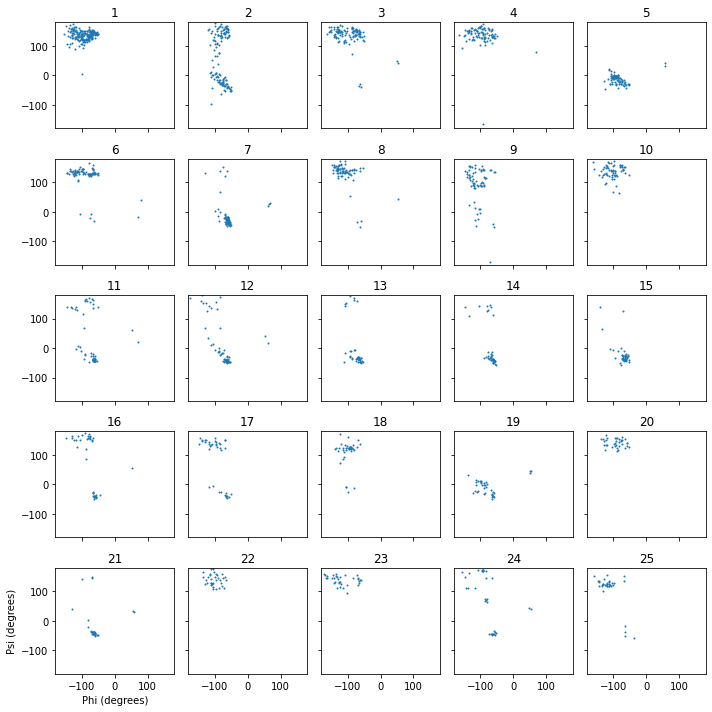

In [19]:
df_parent_ = df_parent[(df_parent.chain=='X') & (df_parent.resnum==10)][['rota', 'CG', 'probe_name', 'phi', 'psi', 'cluster_number', 'cluster_size', 'ABPLE']].drop_duplicates()

fig, axes = plt.subplots(5,5, sharey=True, sharex=True)
cn = 1
for i in range(5):
    for j in range(5):
        axes[i,j].set_title(str(cn))
        axes[i,j].scatter(x=df_parent_[df_parent_.cluster_number == cn].phi, y=df_parent_[df_parent_.cluster_number == cn].psi, s=1)
        axes[i,j].set_xlim([-180,180])
        axes[i,j].set_ylim([-180,180])
        if cn == 21:
            axes[i,j].set_xlabel('Phi (degrees)')
            axes[i,j].set_ylabel('Psi (degrees)')
        cn += 1
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()


Make Ramachandran plots of members with ABPLE == 'A' from top clusters

In [20]:
df_parent_A = df_parent_[df_parent_.ABPLE == 'A']

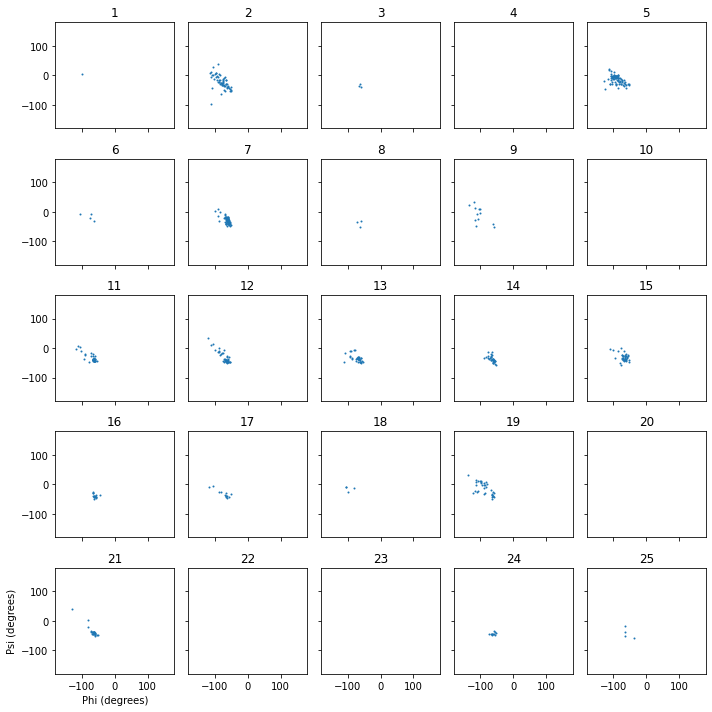

In [21]:
fig, axes = plt.subplots(5,5, sharey=True, sharex=True)
cn = 1
for i in range(5):
    for j in range(5):
        axes[i,j].set_title(str(cn))
        axes[i,j].scatter(x=df_parent_A[df_parent_A.cluster_number == cn].phi, y=df_parent_A[df_parent_A.cluster_number == cn].psi, s=1)
        axes[i,j].set_xlim([-180,180])
        axes[i,j].set_ylim([-180,180])
        if cn == 21:
            axes[i,j].set_xlabel('Phi (degrees)')
            axes[i,j].set_ylabel('Psi (degrees)')
        cn += 1
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()



